In [1]:
import os
import glob
import time
import numpy as np


import torch

import scipy
from scipy import signal
from scipy.signal import butter

import cupy as cp

# Signal Processing
import cupyx.scipy.signal as cs
from cupyx.scipy.signal import butter as cubutter


%matplotlib inline
import matplotlib.pyplot as plt

/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
class Timer:
    def __init__(self, name="cpu"):
        self.name = name
        
    def __enter__(self):
        self.start = time.perf_counter()
        
    def __exit__(self, type, value, trackback):
        self.end = time.perf_counter()
        self.execute_time = self.end - self.start
        print(f"{self.name} execute time : {self.execute_time:.4f} seconds")

In [3]:
eeg_train_path =glob.glob(os.path.join(".","DATA","raw","train","*"))  
eeg_test_path  =glob.glob(os.path.join(".","DATA","raw","test","*"))  
eeg_val_path   =glob.glob(os.path.join(".","DATA","raw","val","*"))  

In [4]:
test = eeg_val_path[0]
eeg  = torch.load(test)["eeg"]
freq = np.arange(len(eeg))
fs   = 1000.

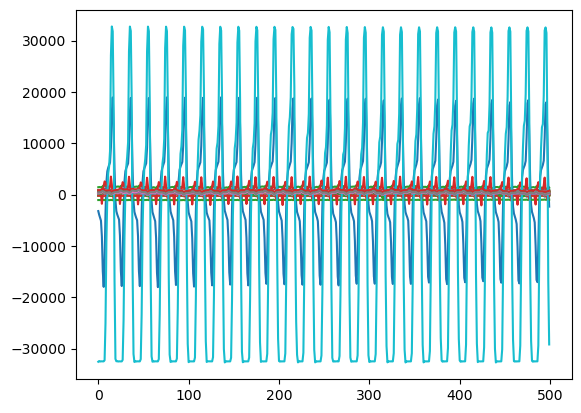

Visualize CPU execute time : 0.1497 seconds


In [5]:
with Timer("Visualize CPU"):
    plt.figure()   
    plt.plot(freq, eeg)
    plt.show()
    plt.close()

/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/cvmi_jeyoung/anaconda3/envs/rapids/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


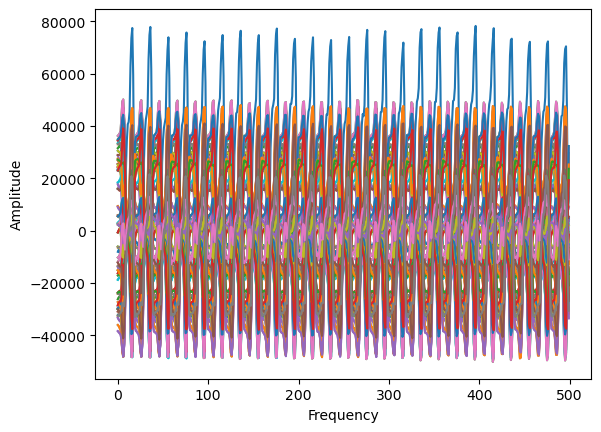

FFT visualize CPU execute time : 0.2387 seconds


In [6]:
with Timer("FFT visualize CPU"):
    eeg_fft = np.fft.fft(eeg)
    plt.plot(freq, eeg_fft)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.show()
    plt.close()

In [7]:
def butter_bandpass_cpu(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter_cpu(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass_cpu(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_lowpass_cpu(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter_cpu(data, cutoff, fs, order=9):
    b, a = butter_lowpass_cpu(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass_cpu(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter_cpu(data, cutoff, fs, order=3):
    b, a = butter_highpass_cpu(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

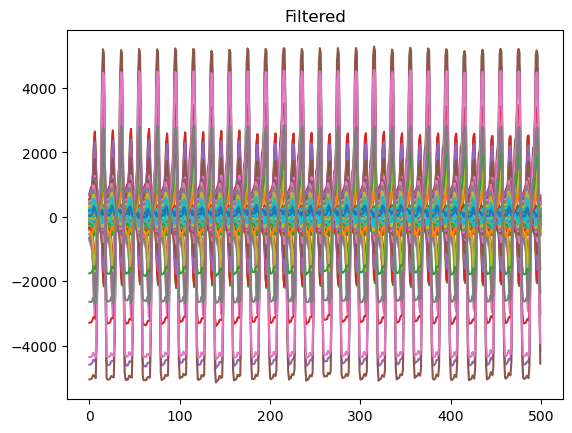

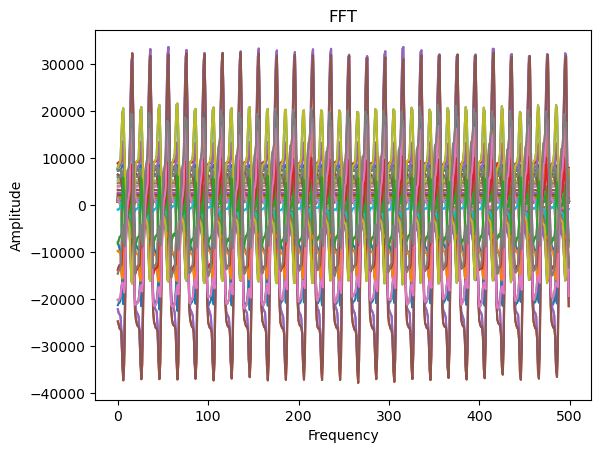

FFT visualize CPU execute time : 0.3832 seconds


In [11]:
with Timer("FFT visualize CPU"):
    lowcut = 5.
    highcut = 95.
    eeg_filtered = butter_bandpass_filter_cpu(eeg, lowcut, highcut, fs, order=5)
    plt.plot(freq, eeg_filtered)
    plt.title("Filtered")
   
    plt.show()

    eeg_filtered_fft = np.fft.fft(eeg_filtered)
    plt.plot(freq, eeg_filtered_fft)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title("FFT")
    plt.show()
    plt.close()


In [9]:
def butter_bandpass_gpu(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cubutter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter_gpu(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass_gpu(lowcut, highcut, fs, order=order)
    y = cs.lfilter(b, a, data)
    return y

def butter_lowpass_gpu(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = cubutter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter_gpu(data, cutoff, fs, order=9):
    b, a = butter_lowpass_gpu(cutoff, fs, order=order)
    y = cs.lfilter(b, a, data)
    return y

def butter_highpass_gpu(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = cu.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter_gpu(data, cutoff, fs, order=3):
    b, a = butter_highpass_gpu(cutoff, fs, order=order)
    y = cs.filtfilt(b, a, data)
    return y